In [1]:
import copy
import csv
import cvxpy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
import sys
sys.path.append('../../')

from skyburst import Job
from skyburst.plot import *
from skyburst import job_gen
from skyburst.simulator import run_simulator

# Assumes 4 nodes, 8 GPUs per node.
run_config = {
    # Size of the cluster (i.e. # of cluster nodes).
    'cluster_size': 4,
    # Number of GPU(s) per cluster node.
    'gpus_per_node': 8,
    # Number of CPU(s) per cluster node.
    'cpus_per_node': 48,
    # Scheduling algorithm specifying order of the queue.
    'sched_alg': 'fifo',
    # How jobs are binpacked into the cluster.
    'binpack_alg': 'best-fit',
    # Waiting policy (how long jobs should wait in the cloud).
    'waiting_policy': 'linear_runtime',
    # Waiting hyperparameter (to be passed to waiting_policy)
    'waiting_factor': 1.25,
    # Sets clipping time for waiting (max time a job should wait)
    'clip_time': 1e9,
    # Enable backfill (assumes time estimator).
    'backfill': False,
    # Enable loop scheduling (just loop through entire queue, remove HoL).
    'loop': False,
    # Enable prediction. (Jobs predict if they can be assigned to cluster before timing out).
    # 0 is no prediction, 1 is perfect oracle
    'predict_wait': 0,
    # Queue length
    'max_queue_length': -1,
    # Time estimator error
    'time_estimator_error': 0,
    # (Deprecated) Algorithm to immediately send job to cloud (without waiting).
    'filter_alg': None,
    # Prints out simulator state at every timestep.
    'verbose': False,
    # Appends python debugger at every timestemp.
    'debug': False,
    # Position for TQDM progress tracker bar.
    'pbar_idx': 0,
    # Jobs to not consider for final metrics at the beg. and end. of simulator.
    'warmup_jobs': 0,
    # Whether to get snapshots and save to result dict
    'snapshot': False,
    # Metadata on job generation (run prior to simulator).
    'jobgen_spec': {
        # Dataset type ['philly', 'philly_gen', 'gen_gpu']
        'dataset': '',
        # Arrival rate of jobs (used in 'gen_gpu', 'philly_gen')
        'arrival_rate': -1,
        # Total number of jobs generated.
        'total_jobs': -1,
        # Avg. Job runtime (used in 'gen_gpu')
        'job_runtime': -1,
    }
}

def binary_search_waiting_factor(jobs, target_avg_waiting, run_config, low=0, high=0.5, max_iter=100):
    iter_count = 0
    while low <= high and iter_count < max_iter:
        mid = (low + high) / 2
        run_config['waiting_factor'] = mid
        stats = run_simulator(jobs, run_config)
        avg_waiting = stats['stats']['avg_waiting']
        
        if abs(avg_waiting - target_avg_waiting) < 0.0005:  # Define a threshold for 'close enough'
            return stats
        elif avg_waiting > target_avg_waiting:
            high = mid - 0.0001
        else:
            low = mid + 0.0001
        iter_count += 1
    return stats

In [2]:
# FOR ARTIFACT EVALUATORS - MODIFY SYSTEM_LOAD ENV VARIABLE TO RUN OUR EXPERIMENTS
SYSTEM_LOAD = 1

# Other variables.
SEED = 13

# System load
# (s=0.75) -> Arrival Rate = 12
# (s=1) -> Arrival Rate = 16
# (s=1.5) -> Arrival Rate = 24
arrival_rate_dict = {
    0.75: 12,
    1: 16,
    1.5: 24,
}
# Generate 500 jobs with poisson arrival and exponential runtime distributions.
jobs = job_gen.generate_synthetic_jobs(arrival_rate=arrival_rate_dict[SYSTEM_LOAD], total_jobs=500, seed=SEED)


# No-Wait

Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 23824.50it/s]

Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            zero-1                            4             304.271            9.85752     7.99361e-18    0.974508     2.30603     4.94484                0.67744              0.985488
No-Wait Avg. Waiting: 7.993605777301126e-18 hr.
No-Wait Cost: 760.678624668322


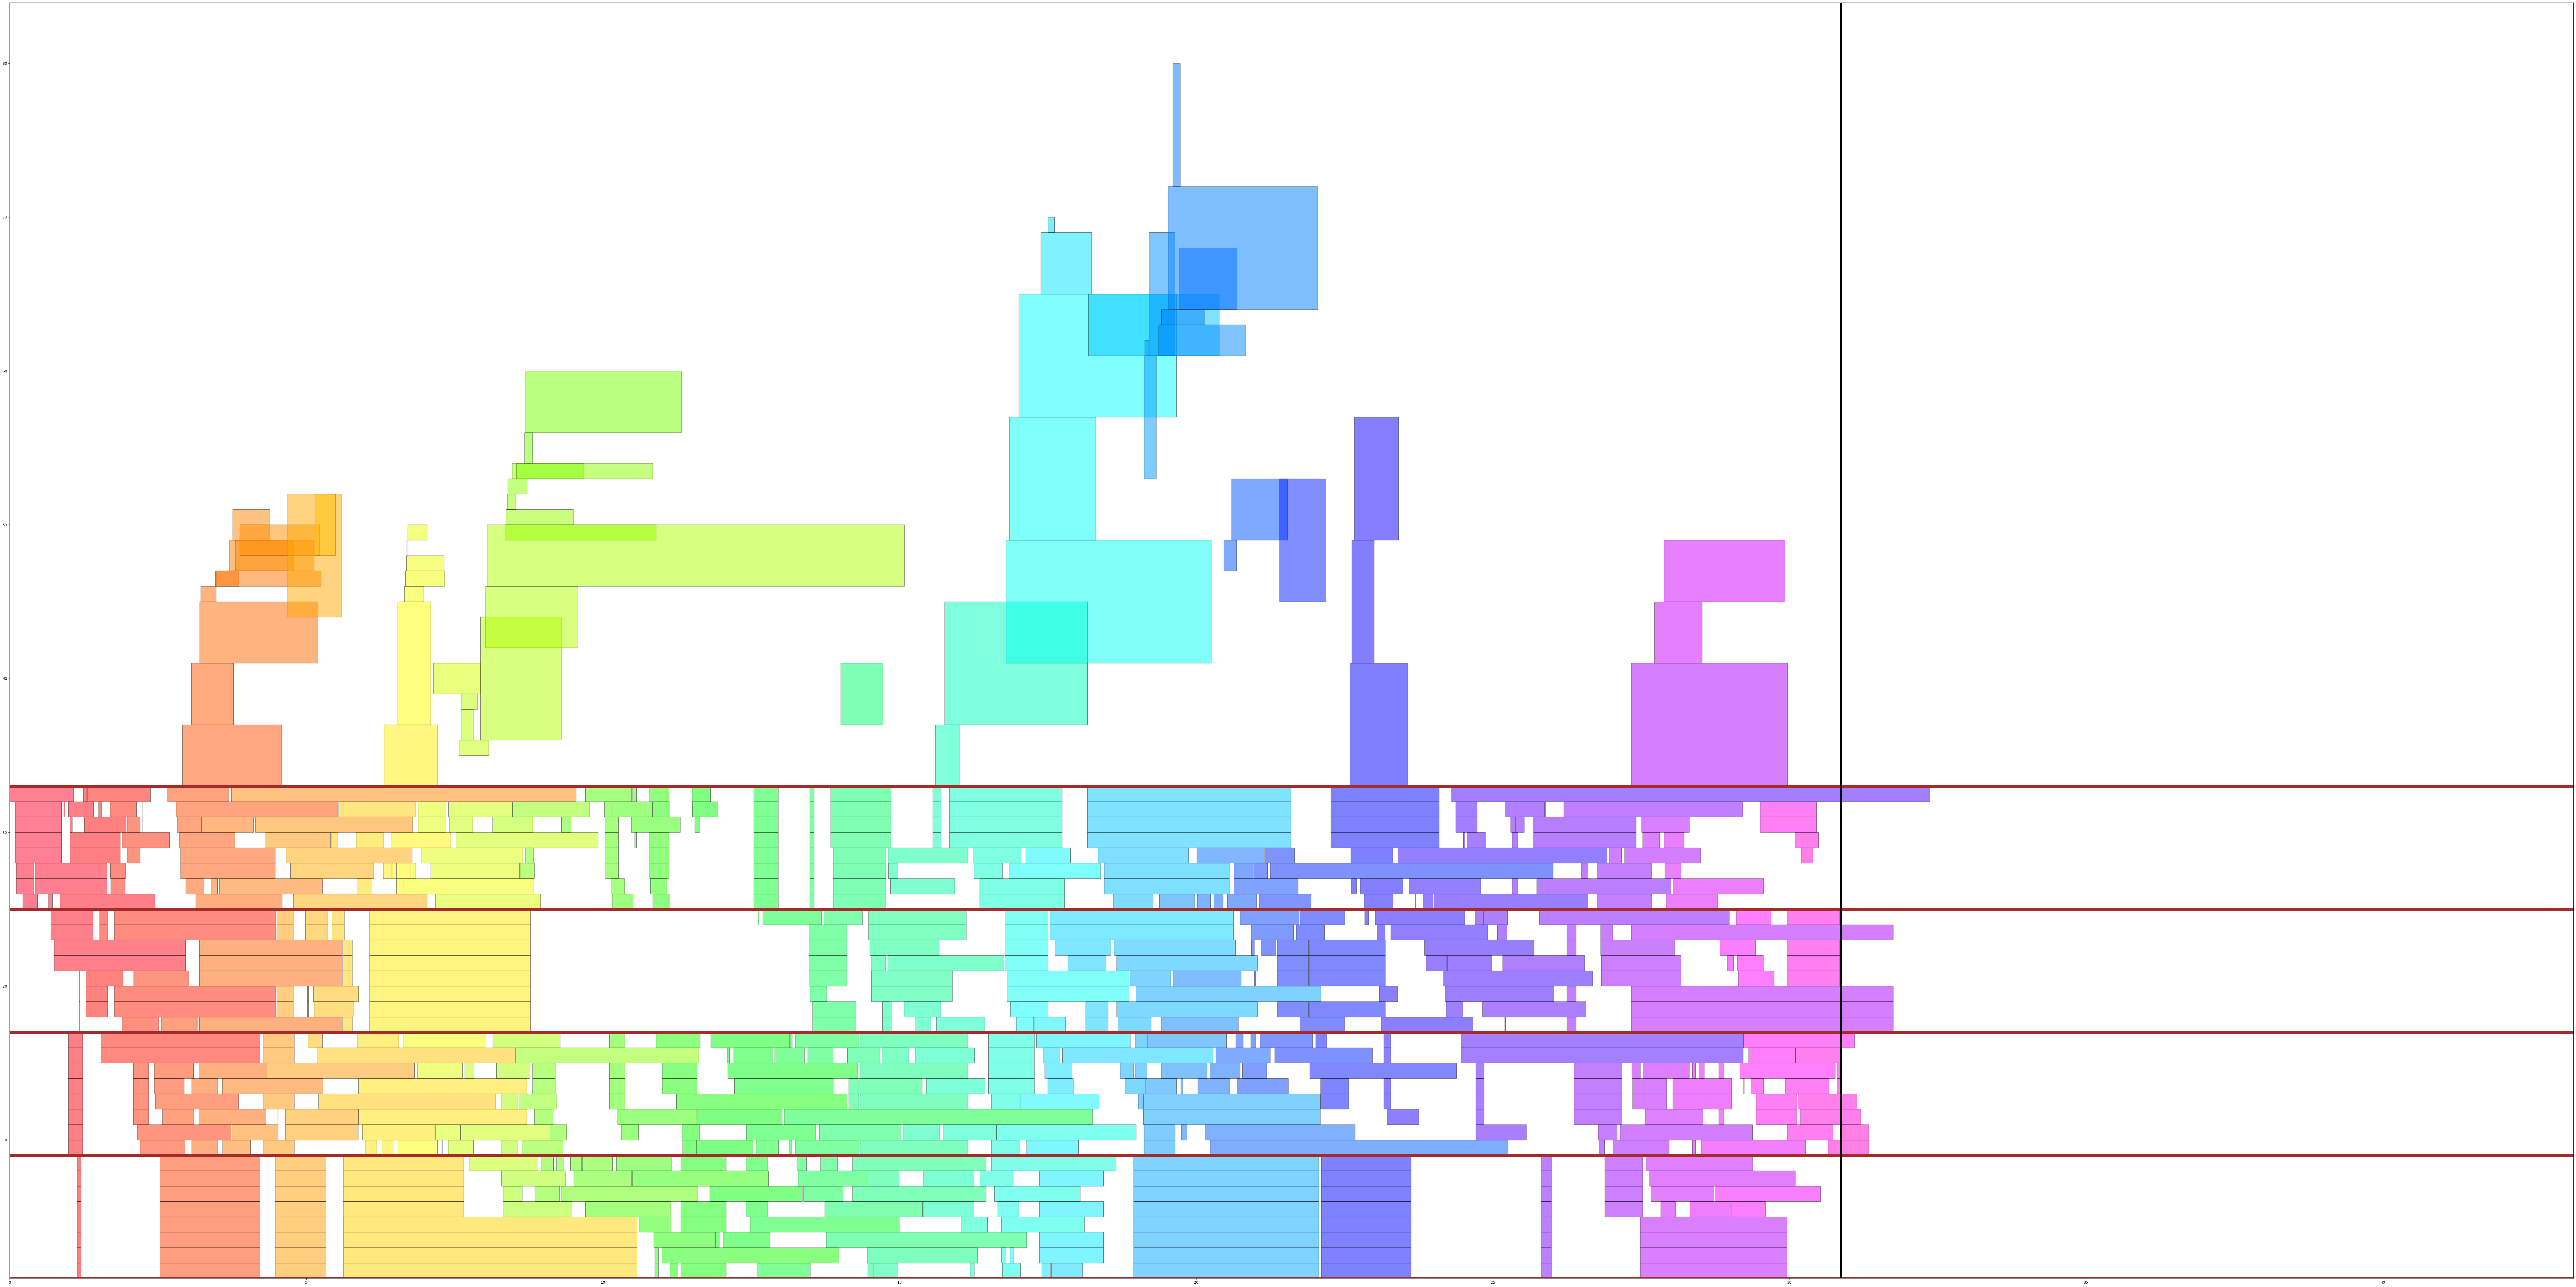

In [3]:
# Config for No-Wait Policy
run_config['waiting_policy'] = 'zero'
run_config['waiting_factor'] =  1
run_config['loop'] = 0
run_config['long_job_thres'] = -1
run_config['preempt_cloud_ratio'] = -1

no_wait = run_simulator(jobs, run_config)
# Note that cloud cost in our simulator assumes 1$/hr for GPU -> $2.5/hr for V100.
# 304.271 *2.5 = 760.6775
print(f"No-Wait Avg. Waiting: {no_wait['stats']['avg_waiting']} hr.")
print(f"No-Wait Cost: {no_wait['stats']['total_cloud_cost']*2.5}")
# Jobs above the red lines are jobs that spillover to the cloud.
plot_trace_spacetime_and_spillover(no_wait, 4)

# Constant-Wait

Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 21188.92it/s]


Sched Policy    Waiting Policy                  # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ----------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            constant-0.24362703932129168                  4             282.221            9.14313       0.0516294     1.02614     2.37339     4.94484               0.698986              0.984709
Constant-Wait Avg. Waiting: 0.051629439137582125 hr.
Constant-Wait Cost: 705.5513640982915


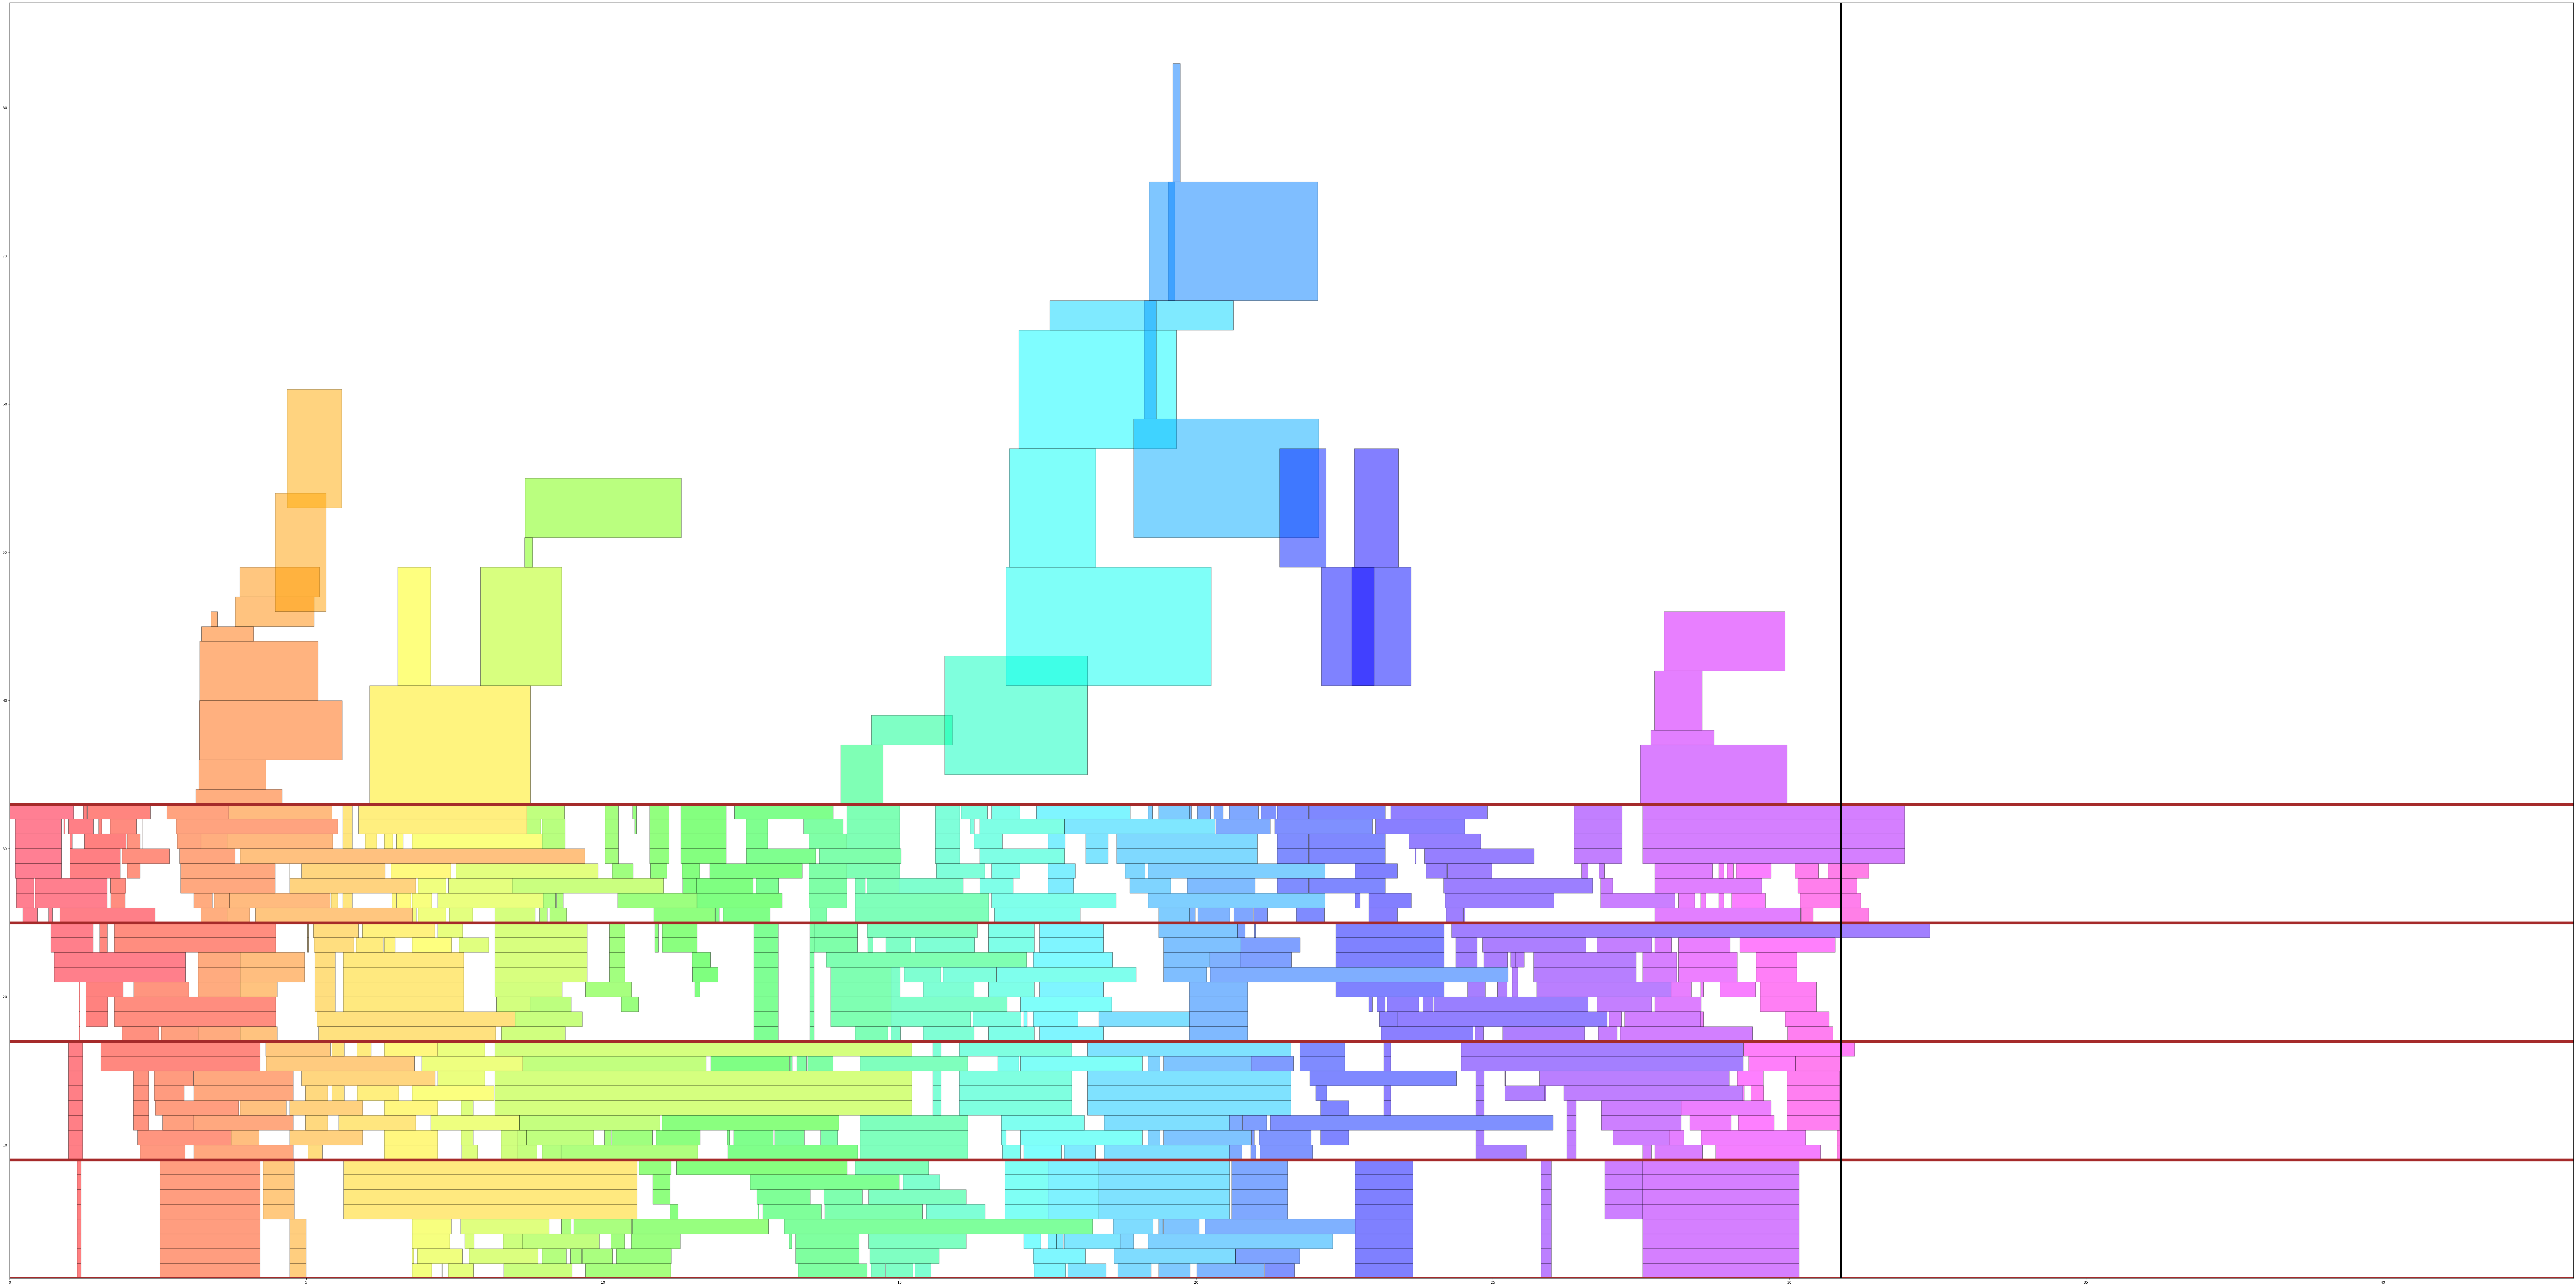

In [4]:
# Constant-Wait
run_config['waiting_policy'] = 'constant'
# Approx 25% waiting budget.
constant_factor =  np.mean([j.runtime for j in jobs])/4
run_config['waiting_factor'] =  constant_factor
run_config['loop'] = 0
run_config['long_job_thres'] = -1
run_config['preempt_cloud_ratio'] = -1

constant_wait = run_simulator(jobs, run_config)
WAITING_TIME = constant_wait['stats']['avg_waiting']
print(f"Constant-Wait Avg. Waiting: {constant_wait['stats']['avg_waiting']} hr.")
print(f"Constant-Wait Cost: {constant_wait['stats']['total_cloud_cost']*2.5}")
plot_trace_spacetime_and_spillover(constant_wait, 4)
# 282.221  * 2.5 = 705.5525

# Starburst - Compute Wait

Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 15560.86it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_cost-0.25                  4             162.686            5.27055        0.147425     1.12193     2.57277     7.03032               0.816483              0.976744


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 19372.33it/s]


Sched Policy    Waiting Policy         # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_cost-0.12495                  4              220.97             7.1588       0.0749201     1.04943     2.45562     5.41469               0.761775              0.971423


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 20535.15it/s]


Sched Policy    Waiting Policy          # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  --------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_cost-0.062425                  4             262.296            8.49764       0.0406526     1.01516     2.37339     5.02421               0.719937              0.982106


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 19829.35it/s]


Sched Policy    Waiting Policy           # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ---------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_cost-0.0936875                  4             233.374            7.56064       0.0597022     1.03421     2.45562     5.19605               0.749218              0.976764


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 19940.59it/s]


Sched Policy    Waiting Policy            # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ----------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_cost-0.07805625                  4             233.601            7.56799       0.0511869      1.0257     2.39487     5.19605               0.748988              0.979435
Compute-Wait Avg. Waiting: 0.0511869390577862 hr.
Compute-Wait Cost: 584.0014327230637


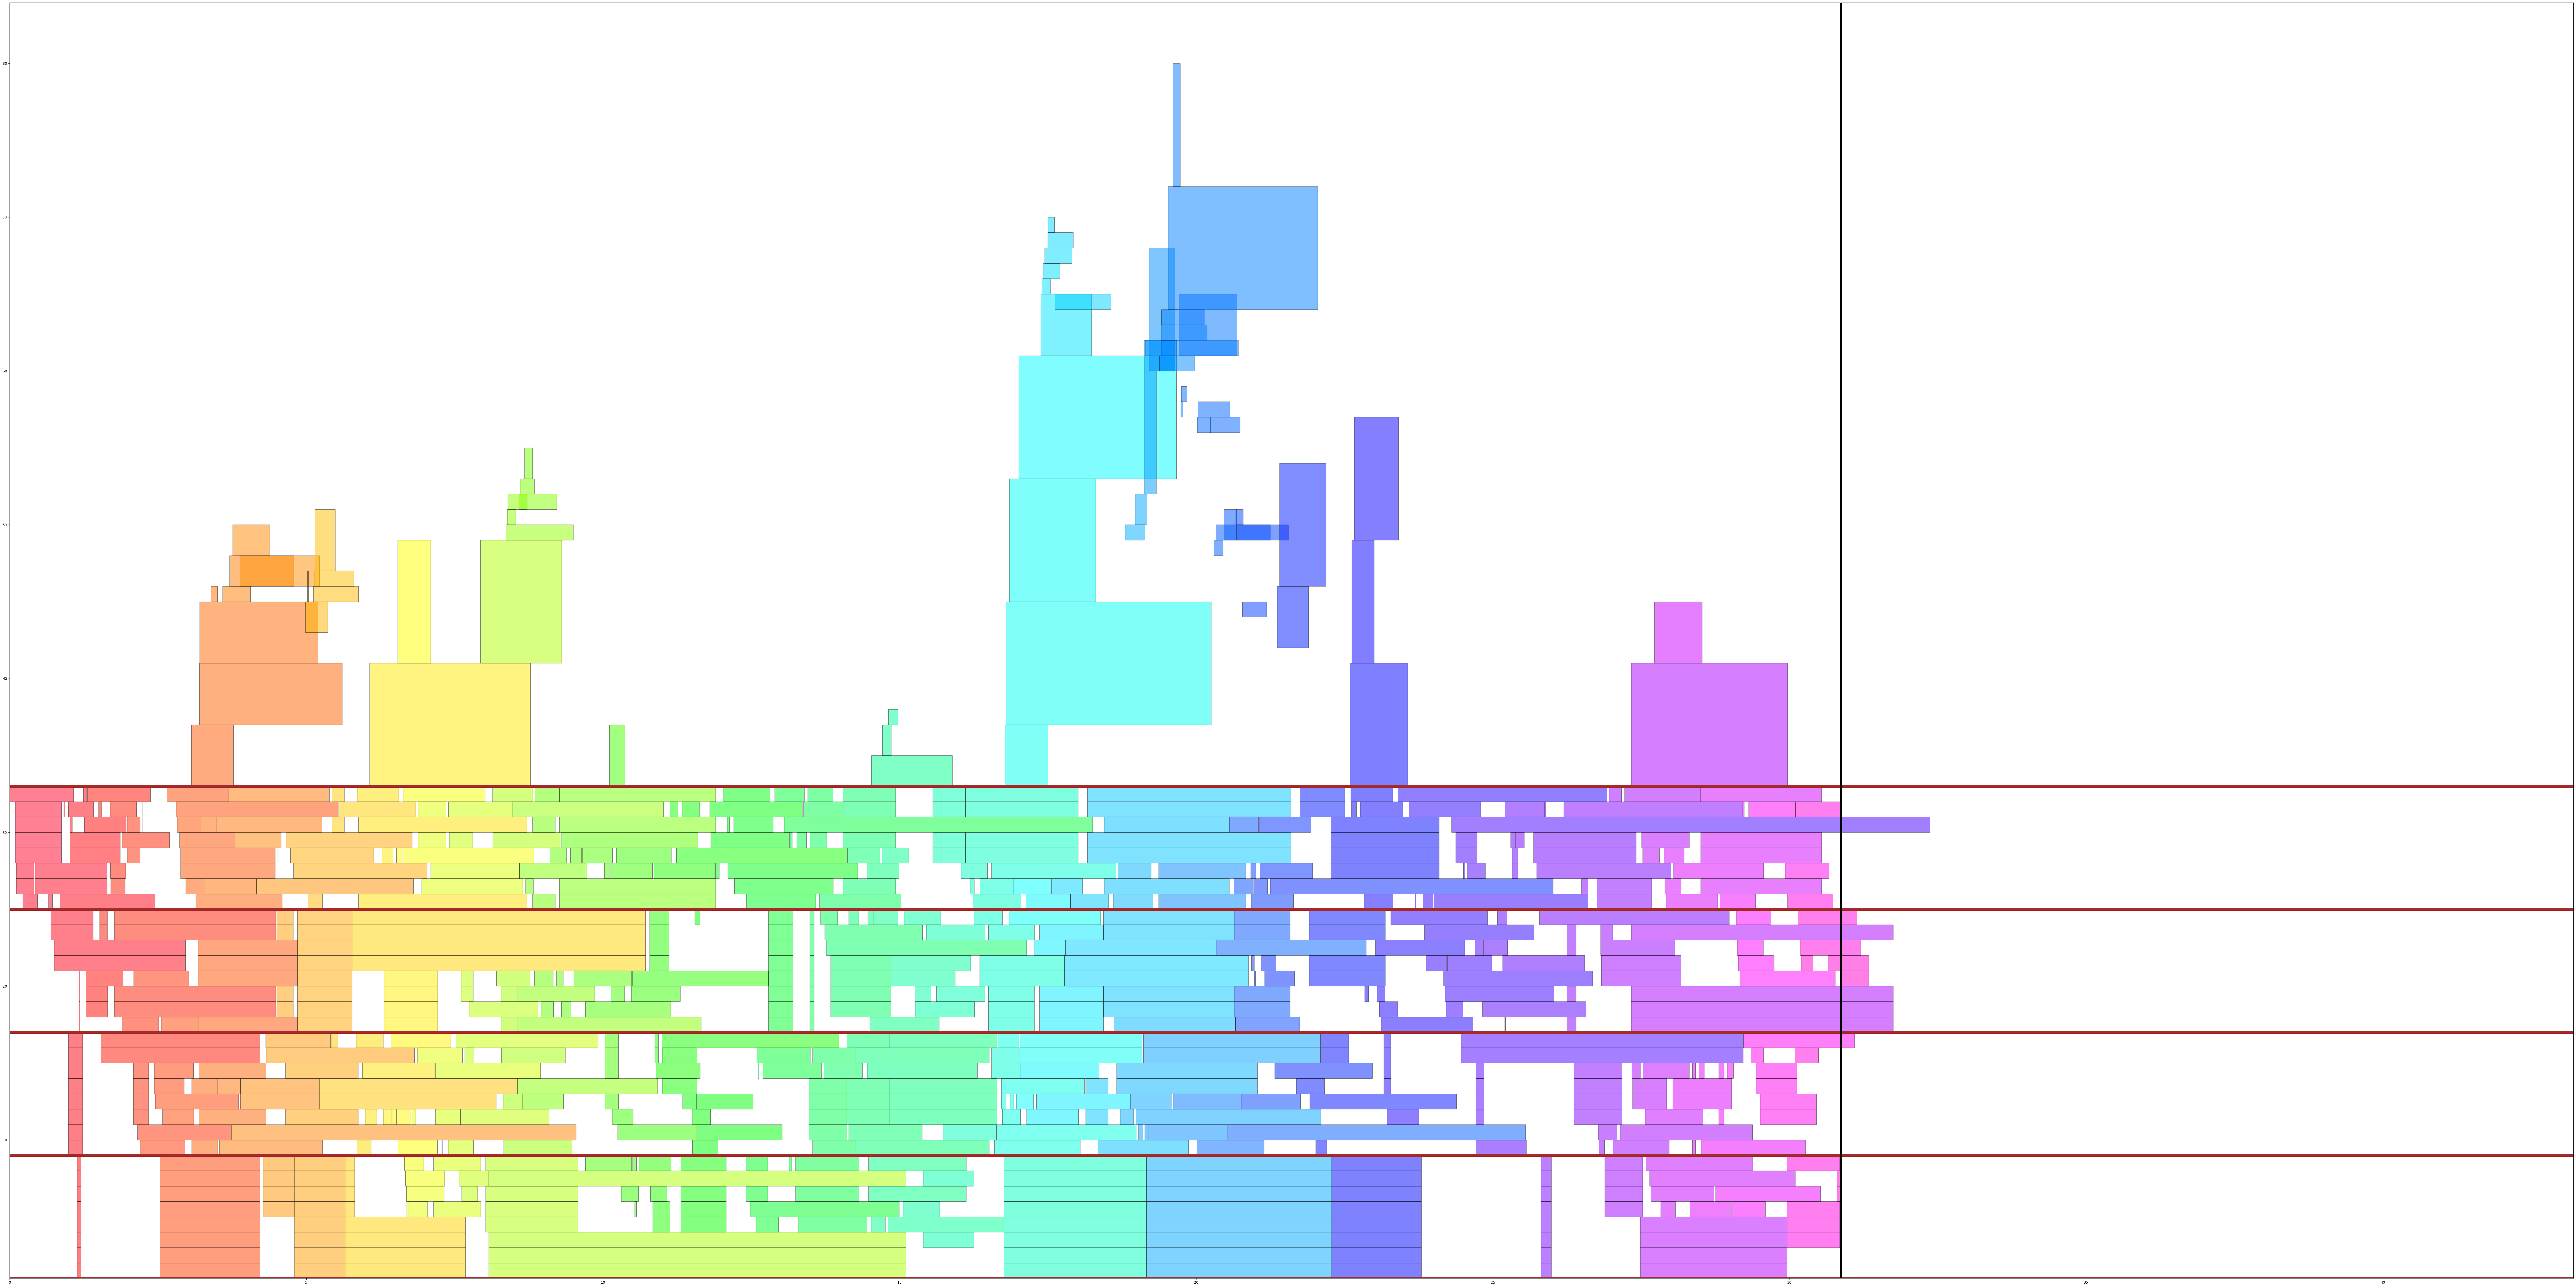

In [5]:
run_config['waiting_policy'] = 'linear_cost'
# Binary search to finetune the value to get similar waiting time as Constant-Wait.
run_config['waiting_factor'] =  0.115
run_config['loop'] = 1
run_config['long_job_thres'] = -1
run_config['preempt_cloud_ratio'] = -1


# Here we figure out what is the right `waiting_factor` to have the equivalent Avg. Waiting time as Constant-Wait. 
# This is done through binary search in this method.
compute_wait = binary_search_waiting_factor(jobs, WAITING_TIME, run_config, max_iter=100)
#run_simulator(jobs, run_config)

print(f"Compute-Wait Avg. Waiting: {compute_wait['stats']['avg_waiting']} hr.")
print(f"Compute-Wait Cost: {compute_wait['stats']['total_cloud_cost']*2.5}")
plot_trace_spacetime_and_spillover(compute_wait, 4)

# Starburst - Star-Wait

Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 8484.89it/s]


Sched Policy    Waiting Policy          # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  --------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.25                  4             149.181            4.83304        0.323402     1.29791     2.83664     8.06068               0.838015              0.964749


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 12030.20it/s]


Sched Policy    Waiting Policy             # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -----------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.12495                  4             179.149            5.80391        0.168453     1.14296     2.70503     5.52804               0.803981              0.969408


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 16038.54it/s]


Sched Policy    Waiting Policy              # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.062425                  4             252.418            8.17763        0.069174     1.04368      2.4307     5.02001               0.739618               0.98165


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 17821.26it/s]


Sched Policy    Waiting Policy               # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.0311625                  4             286.788            9.29109       0.0322332     1.00674     2.30603     4.94484               0.699001              0.985488


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 17391.05it/s]


Sched Policy    Waiting Policy                          # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ------------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.046793749999999995                  4             264.844             8.5802       0.0505893      1.0251     2.42879     5.02001               0.726278              0.984689


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 16912.65it/s]


Sched Policy    Waiting Policy                 # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ---------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.054609375                  4             274.333            8.88759       0.0637454     1.03825     2.45562     5.08408               0.715723              0.983169


Jobs progress:   0%|          | 0/500 [00:00<?, ?it/s]

Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 16689.10it/s]


Sched Policy    Waiting Policy                  # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ----------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.0507015625                  4             274.874            8.90511       0.0603233     1.03483     2.45562     5.08408               0.715619              0.983929


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 16992.41it/s]


Sched Policy    Waiting Policy                         # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -----------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.04874765624999999                  4             274.874            8.90511       0.0585178     1.03303     2.43589     5.08408               0.715619              0.984309


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 17664.69it/s]


Sched Policy    Waiting Policy                          # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ------------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.047770703124999994                  4             262.924            8.51798       0.0524313     1.02694     2.44051     5.02001               0.728729              0.984499


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 17924.53it/s]


Sched Policy    Waiting Policy                          # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ------------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.047282226562499995                  4             264.844             8.5802       0.0510114     1.02552      2.4307     5.02001               0.726278              0.984594


Jobs progress: 100%|██████████| 500/500 [00:00<00:00, 18042.03it/s]


Sched Policy    Waiting Policy                         # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -----------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.04752646484374999                  4             264.844             8.5802       0.0512224     1.02573      2.4307     5.02001               0.726278              0.984546
Star-Wait Avg. Waiting: 0.05122238598376568 hr.
Compute-Wait Cost: 662.1111516119638


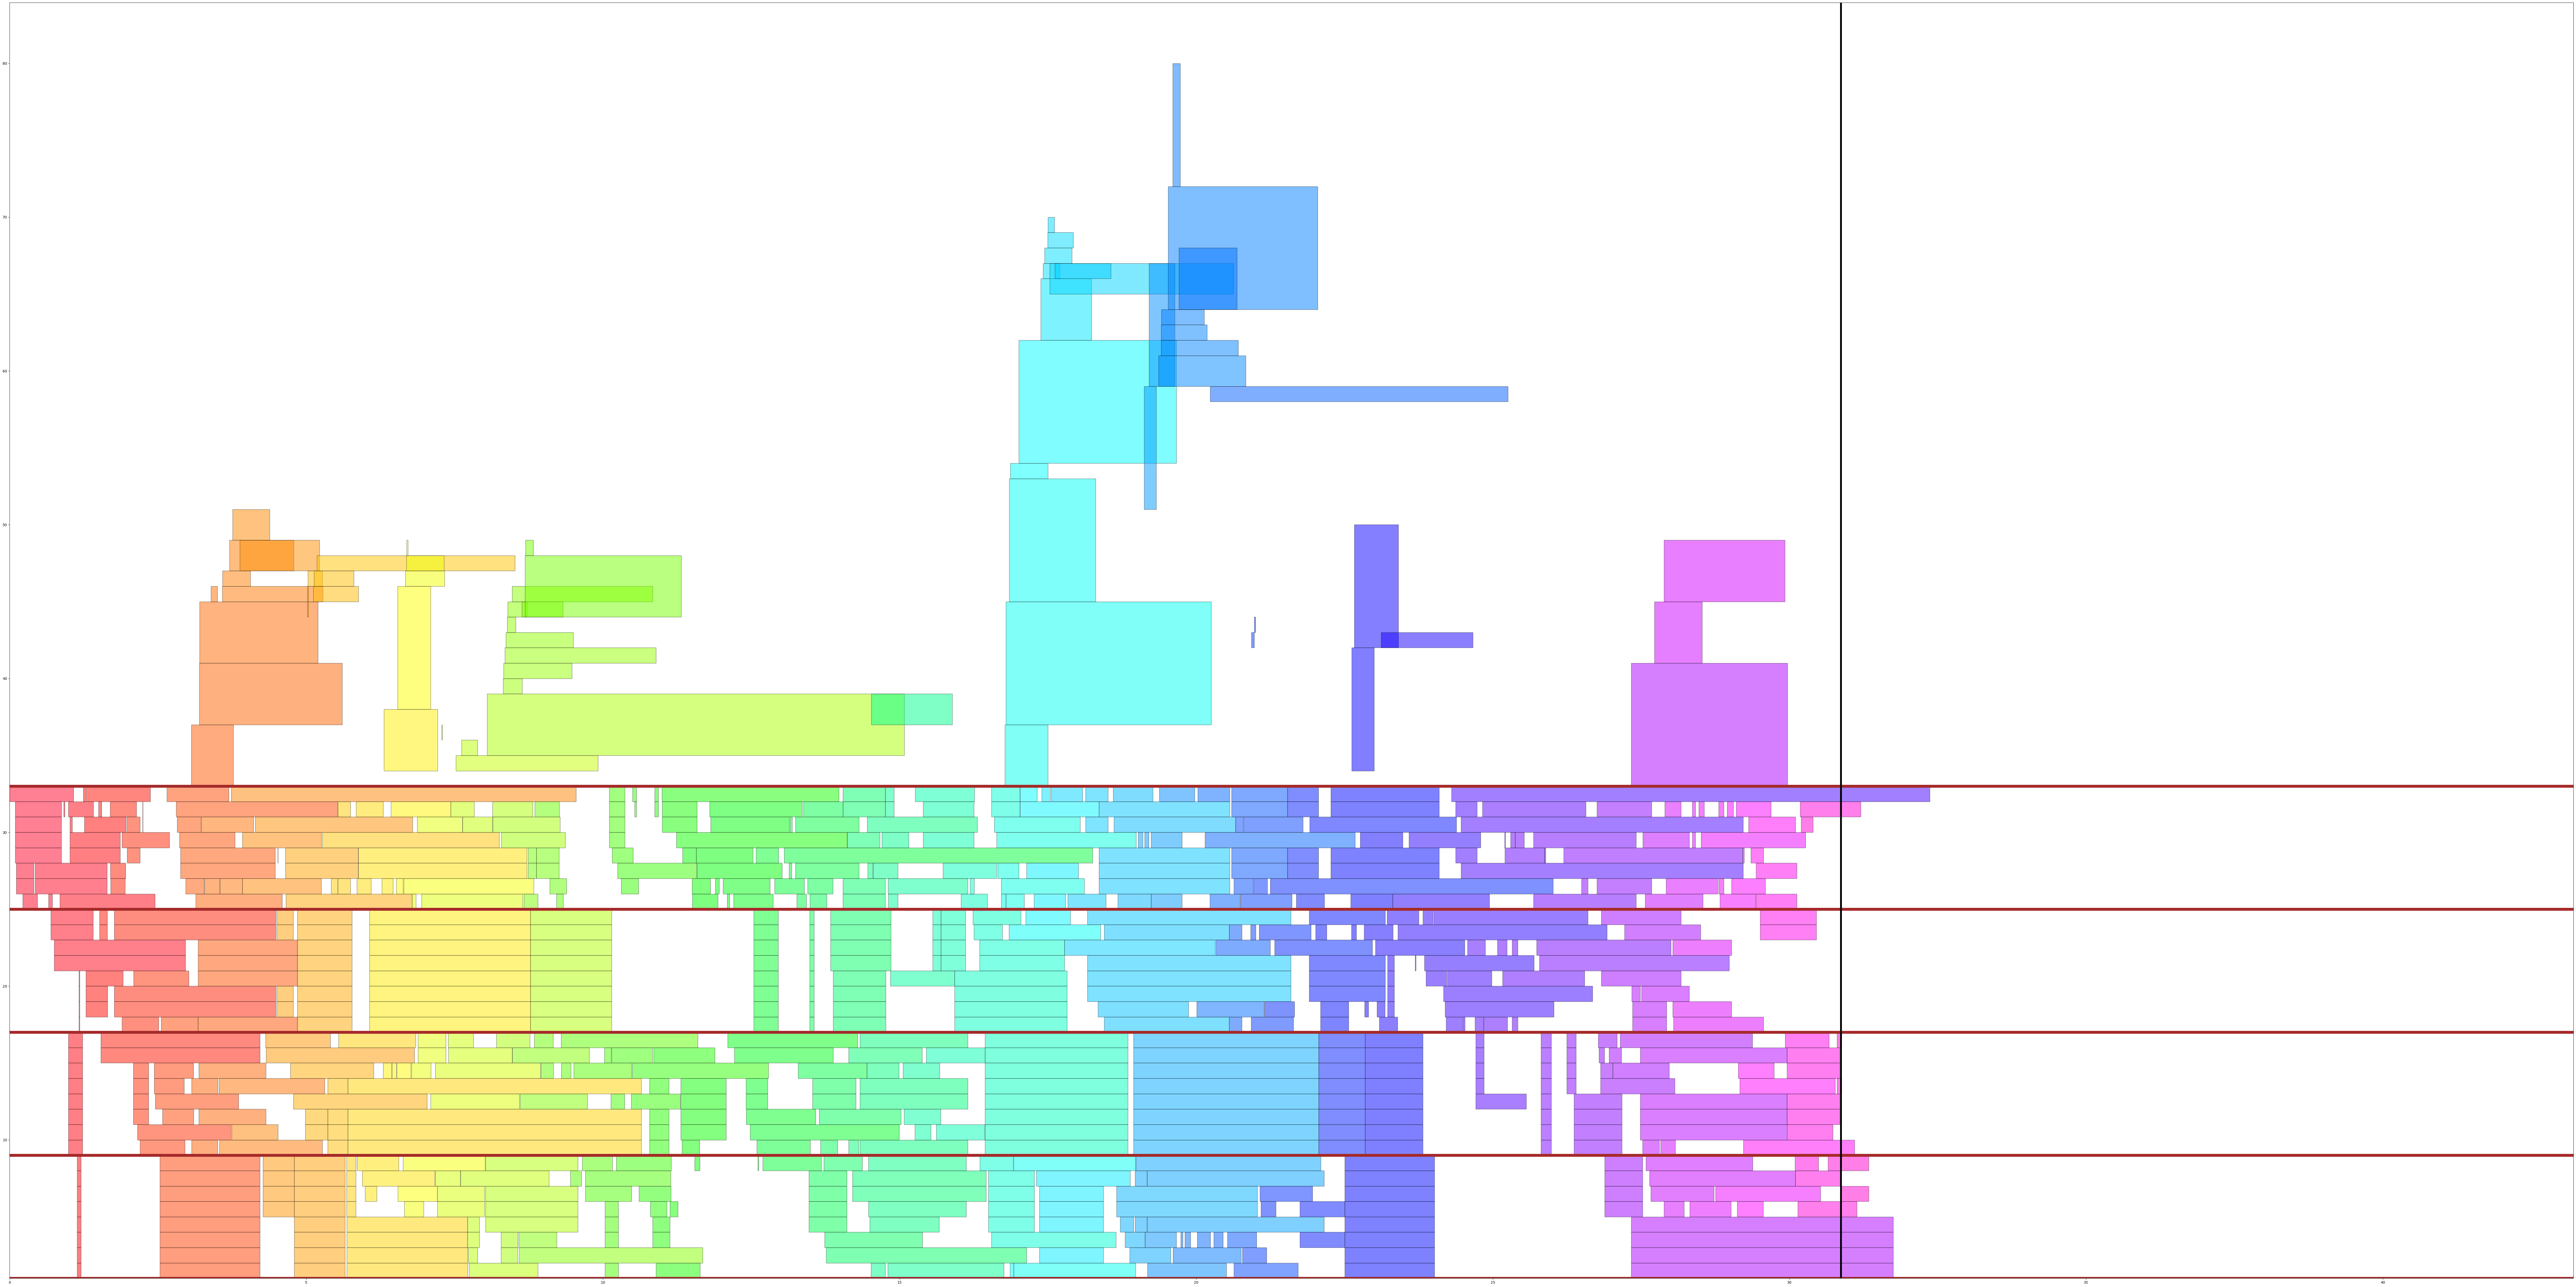

In [6]:
run_config['waiting_policy'] = 'linear_capacity'
# Binary search to finetune the value to get similar waiting time as Constant-Wait.
run_config['waiting_factor'] =  0.048
run_config['loop'] = 1
run_config['long_job_thres'] = 0.0625
run_config['preempt_cloud_ratio'] = 3

# Here we figure out what is the right `waiting_factor` to have the equivalent Avg. Waiting time as Constant-Wait. 
# This is done through binary search in this method.
star_wait = binary_search_waiting_factor(jobs, WAITING_TIME, run_config, max_iter=100)

print(f"Star-Wait Avg. Waiting: {star_wait['stats']['avg_waiting']} hr.")
print(f"Compute-Wait Cost: {star_wait['stats']['total_cloud_cost']*2.5}")
plot_trace_spacetime_and_spillover(star_wait, 4)

# MILP Optimal Solver

We note our solver uses CVXPY and Gurobi optimization software. We provide the license to use Guroibi in `gurobi.lic` (this will expire in 90 days). If the code block below fails, Gurobi is not properly installed.

In [7]:
def milp_solver_v3(jobs: List[Job], nodes, time_limit=8):
    bin_width = 8
    bin_height = 1e6
    num_jobs = len(jobs)
    arrivals = np.array([j.arrival for j in jobs])
    runtimes = np.array([j.runtime for j in jobs])
    
    avg_runtime = np.mean(runtimes)
    wait_time_limit = WAITING_TIME * len(jobs)
    
    num_gpus = []
    num_nodes = []
    costs = []
    for j in jobs:
        gpus = j.num_gpus
        if gpus > bin_width:
            assert gpus % bin_width == 0
            num_nodes.append(int(gpus/bin_width))
            num_gpus.append(bin_width)
            costs.append(j.cost/int(gpus/bin_width))
        else:
            num_nodes.append(1)
            num_gpus.append(gpus)
            costs.append(j.cost)
    
    num_gpus = np.array(num_gpus)
    num_nodes = np.array(num_nodes)
    costs = np.array(costs).reshape((num_jobs, 1))
    
    
    
    left = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    bottom = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    selection =  cvxpy.Variable((nodes, num_jobs), boolean=True)
    x_w = cvxpy.Variable((num_jobs,), integer=True)
    y_h = cvxpy.Variable((num_jobs,))
    wait_times = cvxpy.Variable((num_jobs,))
    all_or_nothing = cvxpy.Variable((num_jobs,), boolean=True)
    
    constraints = []
    
    # Restriction on X,Y coordinates
    constraints.append(x_w >= 0)
    constraints.append(x_w <= bin_width - num_gpus)
    constraints.append(y_h >= arrivals)
    constraints.append(y_h <=arrivals + wait_times)
    constraints.append(wait_times>=0)
    constraints.append(cvxpy.sum(wait_times) <= wait_time_limit)
    # Restriction on selection
    constraints.append(cvxpy.sum(selection, axis=0) == cvxpy.multiply(num_nodes, all_or_nothing))
    
    # Restriction on Boxes not intersecting
    triangle_filter = 100*np.triu(np.ones((num_jobs, num_jobs)))
    var_filter = triangle_filter + left + left.T + bottom + bottom.T 

    # Add constraints for each node boxes
    for n_idx in range(nodes):
        row = selection[n_idx]
        outer_sum = cvxpy.reshape(row, (num_jobs, 1)) + cvxpy.reshape(row, (1, num_jobs))
        constraints.append(var_filter + (2 - outer_sum) >=1)

    eq_1 = cvxpy.reshape(x_w + num_gpus, (num_jobs, 1)) - cvxpy.reshape(x_w, (1, num_jobs)) + bin_width * left <= bin_width 
    eq_2 = cvxpy.reshape(y_h + runtimes, (num_jobs, 1)) - cvxpy.reshape(y_h, (1, num_jobs)) + bin_height * bottom <= bin_height
    constraints.append(eq_1)
    constraints.append(eq_2)

    import gurobipy
    env = gurobipy.Env()
    env.setParam('TimeLimit', 3600*time_limit) # in seconds
    
    total_utility = cvxpy.sum(selection@costs)
    #total_utility = cvxpy.sum(total_utility)
    super_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)

    # Solving the problem
    opts = {'limits/time' : 7200, 'parallel/minnthreads': 32, 'parallel/maxnthreads': 64} #{'maxiters' : 5000}
    super_problem.solve(solver=cvxpy.GUROBI, verbose=True, env=env)#, scip_params = opts)

    # Restriction on intersections
    return (left, bottom, selection, x_w, y_h, all_or_nothing)

# Set time limit here! We show results for 8 hours, but we encourage artifact evaluators to try out different solving times. It is very difficult to get the MILP to do better than Starburst!
variables  = milp_solver_v3(jobs, 4, time_limit=8)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2514324


Academic license 2514324 - for non-commercial use only - registered to ac___@ethz.ch
Set parameter TimeLimit to value 28800
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 11 12:15:25 PM: Your problem has 504000 variables, 13 constraints, and 0 parameters.
(CVXPY) May 11 12:15:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 12:15:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 12:15:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 12:15:25 PM: Compili

/opt/conda/envs/sky/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimal MILP Cost: 524.4844635204279


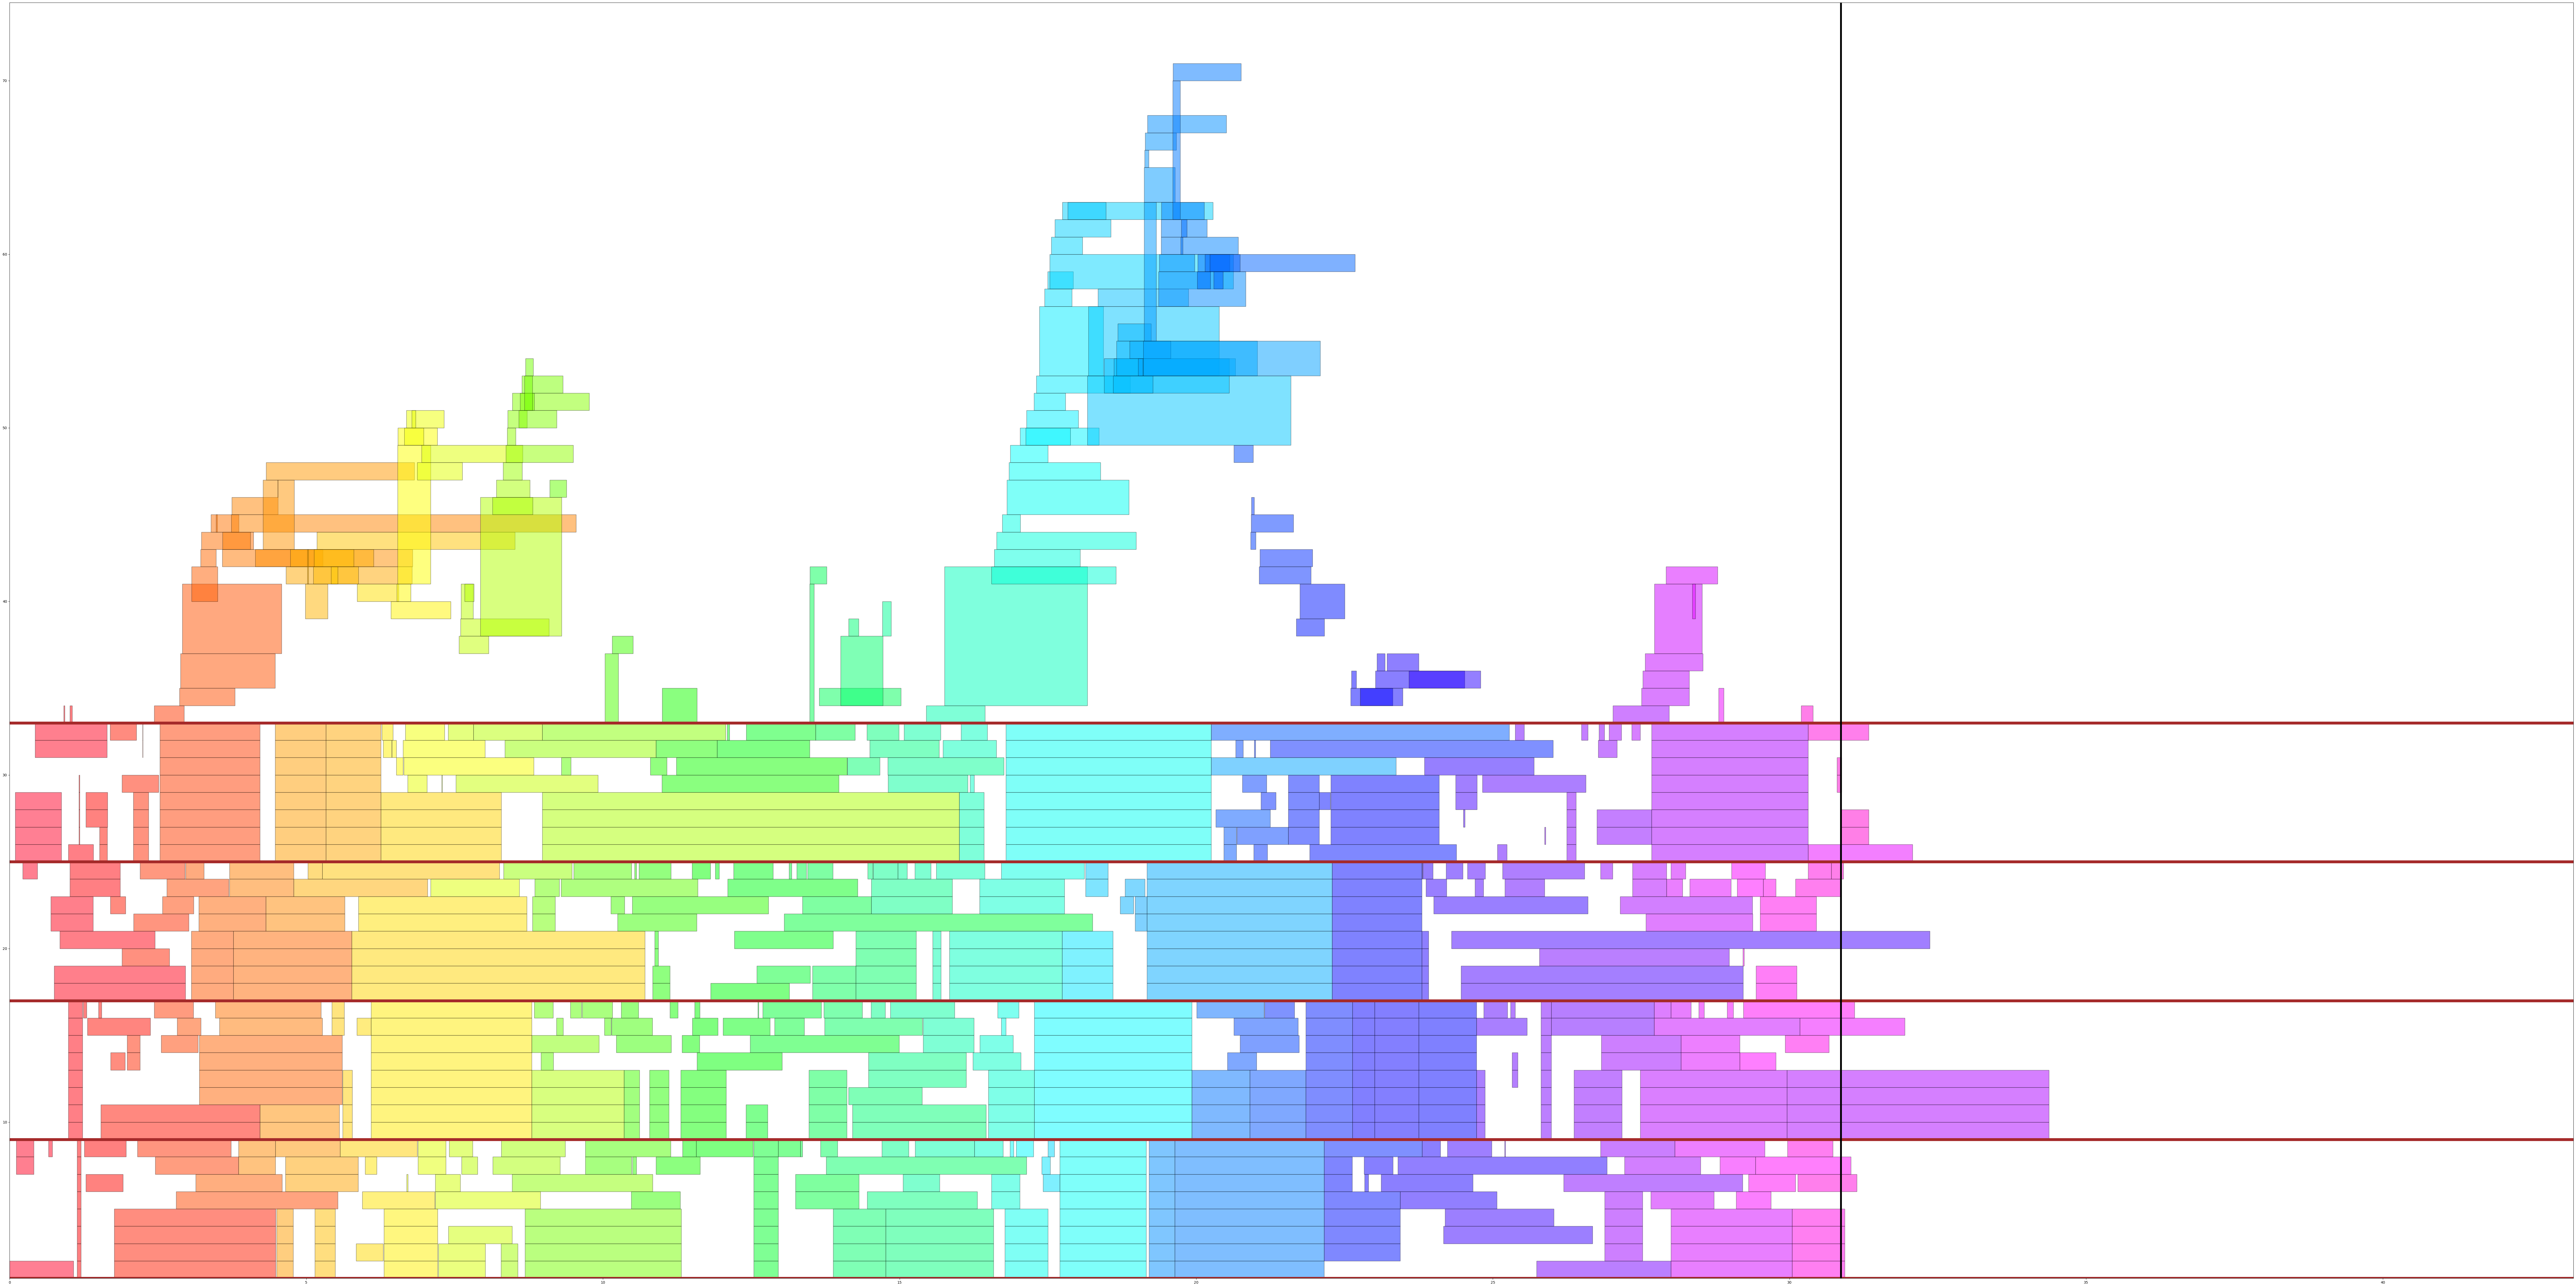

In [8]:
left, bottom, selection, x_w, y_h, all_or_nothing = variables

copy_jobs = copy.deepcopy(jobs)
copy_jobs.sort(key=lambda x: x.idx)

gpu_values = selection.value
summed_values = np.sum(gpu_values, axis=0)
# print(summed_values)
cloud_cost = 0
sum_wait =0
for j in copy_jobs:
    idx = j.idx
    if summed_values[idx] == 0:
        cloud_cost += j.cost
        continue
    j.start = y_h.value[idx]
    for gpu_idx, gpu_v in enumerate(gpu_values[:,idx]):
        if gpu_v ==1:
            j.allocated_gpus[gpu_idx] = list(range(int(x_w.value[idx]), int(x_w.value[idx]) + j.num_gpus))    
print(f"Optimal MILP Cost: {cloud_cost*2.5}")
finished_jobs = copy_jobs
result_dict = {
    'idx': np.array([j.idx for j in finished_jobs]),
    'arrival': np.array([j.arrival for j in finished_jobs]),
    'start': np.array([j.start for j in finished_jobs]),
    'runtime': np.array([j.runtime for j in finished_jobs]),
    'deadline': np.array([j.deadline for j in finished_jobs]),
    'num_gpus': np.array([j.num_gpus for j in finished_jobs]),
    'state': np.array([j.state for j in finished_jobs]),
    'allocated_gpus': np.array([j.allocated_gpus for j in finished_jobs]),
}
plot_trace_spacetime_and_spillover(result_dict, 4)